# Домашнее задание №3 "Задачи сегментации и детекции" по модулю "Компьютерное зрение"

Задание: В данном задании вам предстоит помочь The Nature Conservancy в борьбе с рыбаками-браконьерами. Необходимо по снимкам с камеры на рыболовецком судне классифицировать улов. За основу решения предлагается взять модель детектора:
007-detection.ipynb

Решение необходимо прислать в виде ссылки на ipython-ноутбук с указанием значения метрики на Leaderboard.

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [181]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.17.0


In [182]:
# Подключение google disc
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [184]:
# Проверка доступности видеокарты
# cuda - видеокарта

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Загружаем разметку

In [185]:
import os
import json
from glob import glob

TRAIN_PREFIX = '/content/drive/MyDrive/Working_1/007/data/fish/train'
TEST_PREFIX =  '/content/drive/MyDrive/Working_1/007/data/fish/test_std1'

In [186]:
# Чтение данных по картинкам из файлов json
# ---> название рыбы - ключ словаря
# по каждой картинке данные:

def load_annotations():

    boxes = dict()
    for path in glob('/content/drive/MyDrive/Working_1/007/data/fish/boxes/*.json'):

        # path - сссылка на группу картинок по видам рыб в папке boxes
        # заголовок: split( separator , maxsplit) :максимальное кол-во разделений
        # shark_labels.json ---> shark

        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):

                # чтение ключа annotation['filename']
                basename = os.path.basename(annotation['filename'])

                # изменение значения ключа annotation['filename'] на полную ссылку
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)

                #Добавлена метка класса рыбы в аннотацию
                #-------------------

                annotation['fish_class'] =  label.upper()

                #-------------------

                # чтение ключа annotation['annotations']
                for rect in annotation['annotations']:

                    # изменение координат прямоугольника
                    # width, height - значения словаря
                    # x += половина ширины, y += половина высоты
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2

                if os.path.isfile(annotation['filename']):

                    # при первом чтении ключа label - создает пустой список
                    # добавляет описания по каждой картинке по ключу - конкретная рыба
                    boxes.setdefault(label, []).append(annotation)

    return boxes

In [187]:
# отрисовка прямоугольников, содержащих рыбу на картинке

def draw_boxes(annotation, rectangles=None, image_size=None):

    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:

            # точка (0,0) - левый верхний угол картинки
            # левая верхняя точка прямоугольника
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))

            # правая нижняя точка прямоугольника
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))

            # рисует прямоугольник по координатам двух угловых точек
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=4)
        return img

    scale_x, scale_y = 1., 1.

    # 1. параметр cv2.IMREAD_COLOR преобразует изображение в 3-канальное цветное изображение BGR.
    # 2. Срез также может включать многоточие (…), чтобы сделать кортеж выделения той же длины,
    # что и размерность массива. Если многоточие используется в позиции строки, он вернет ndarray,
    # состоящий из элементов в строках.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    # ---> считывает все данные в файле картинки при чтении от конца в начало с шагом -1

    if image_size is not None:
    # cv2 выдает размер картинки в порядке (y,x)

        # resize картинки в заданный формат
        # при уменьшении разрешения картинки уменьшается scale - масштаб прямоугольников
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    # рисует на картинке прямоугольники с учетом измененного масштаба

    # получает данные о прямоугольнике по ключу 'annotations', не находит ---> []
    # рисует с учетом масштабов
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    # при сохранении исходного масштаба картинки
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [188]:
boxes = load_annotations()  # загружаем разметку детекций

In [189]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,shark,4
1,dol,2
2,alb,27
3,bet,5
4,lag,2
5,yft,12


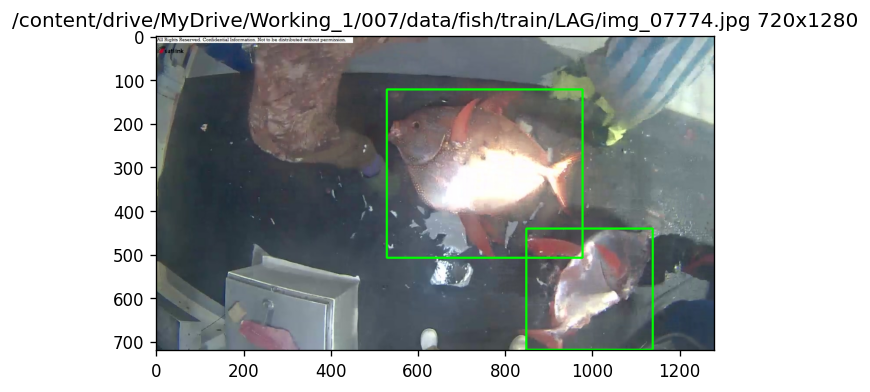

In [190]:
# Визуализация изображения с учетом координат прямоугольника с рыбой

from matplotlib import pyplot as plt

annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

In [191]:
# Предварительный разбор синтаксиса 1

#  [] второй параметр sum - start ---> начать с пуcтого списка
# и добавлять через запятую по одному значения boxes.values

sum(boxes.values(),[])[0]

{'annotations': [{'class': 'rect',
   'height': 80.00000000000017,
   'width': 150.00000000000028,
   'x': 553.0000000000014,
   'y': 480.00000000000114}],
 'class': 'image',
 'filename': '/content/drive/MyDrive/Working_1/007/data/fish/train/SHARK/img_07484.jpg',
 'fish_class': 'SHARK'}

In [192]:
# Предварительный разбор синтаксиса 2

# вытаскиваем данные, относящиеся к локальным прямоугольникам с координатами рыб
sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])[0]

{'class': 'rect',
 'height': 80.00000000000017,
 'width': 150.00000000000028,
 'x': 553.0000000000014,
 'y': 480.00000000000114}

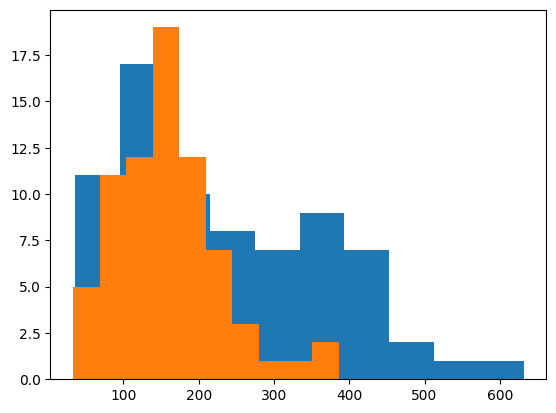

In [193]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

# blue colour
# распределение по ширине прямоугольников в рыбами
plt.hist(widths)

# brown colour
# распределение по высоте прямоугольников в рыбами
plt.hist(heights);

# Экстрактор признаков

In [194]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
# для этого фиксируем веса всех слоев, кроме последних 5

for layer in features.layers[:-5]:
    layer.trainable = False

# выходной тензор
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


In [195]:
# Базовая модель
features.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 750, 1200, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 750, 1200, 64)       │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 750, 1200, 64)       │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 375, 600, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 375, 600, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 375, 600, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 187, 300, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 187, 300, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 93, 150, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 93, 150, 512)        │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 46, 75, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 23, 37, 512)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

# Сетка якорей (anchor grid)

In [196]:
FEATURE_SHAPE = (feature_tensor.shape[1],     # высота карты признака (h)
                 feature_tensor.shape[2])     # ширина карты признака (w)
                                              # feature_tensor.shape[3] = 512 - количество карт признаков

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]   # 750/23 ---> >32.608 : соотношение по высоте между входным и выходным изображ
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]    # 1200/37 --> >32.432 : соотношение по ширине

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

# сетка якорей, размер определяется соотношением
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

# ANCHOR_CENTERS - экземпляр, возвращающий плотную многомерную «сетку».
#  --> np.mgrid[16.3:750:32.6, 16.2:1200:32.4], всего точек 23*37 (начинаем с половинки, 23 точки, остается половинка справа)

In [ ]:
ANCHOR_CENTERS[1]

array([[  16.21621622,   48.64864865,   81.08108108,  113.51351351,
         145.94594595,  178.37837838,  210.81081081,  243.24324324,
         275.67567568,  308.10810811,  340.54054054,  372.97297297,
         405.40540541,  437.83783784,  470.27027027,  502.7027027 ,
         535.13513514,  567.56756757,  600.        ,  632.43243243,
         664.86486486,  697.2972973 ,  729.72972973,  762.16216216,
         794.59459459,  827.02702703,  859.45945946,  891.89189189,
         924.32432432,  956.75675676,  989.18918919, 1021.62162162,
        1054.05405405, 1086.48648649, 1118.91891892, 1151.35135135,
        1183.78378378],
       [  16.21621622,   48.64864865,   81.08108108,  113.51351351,
         145.94594595,  178.37837838,  210.81081081,  243.24324324,
         275.67567568,  308.10810811,  340.54054054,  372.97297297,
         405.40540541,  437.83783784,  470.27027027,  502.7027027 ,
         535.13513514,  567.56756757,  600.        ,  632.43243243,
         664.86486486,  

In [197]:
# Intersection over union - пересечение при обьединении множеств

# Функция находит площадь пересечения фактического прямоугольника с рыбой
# и подбираемого анкерного квадрата, сканирующего изображение

def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):

    # rect: x,y - координаты центра прямоугольника
    # находим фактические угловые координаты прямоугольника
    # x1,y1 - минимальные, x2,y2 - максимальные

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    # угловые координаты анкерного квадрата размером 150 на 150
    # получаем из координат его центра
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    # сравниваем фактический прямоугольник с анкерным квадратом
    # если анкерный квадрат правее фактического прямоугольника -- > dx<0
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    # пересечение
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

In [198]:
# итерируемся по карте признака размером 23*37, сначала по высоте, затем по ширине
# для каждой точки находим координаты анкерного квадрата
# и вычисляем iou с фактическим прямоугольником

# функция возвращает 5-мерный вектор для каждой точки карты признаков 23*37: по координатам
# оценка score = 1 , если iou > 0.5 или лучший score по всем анкерным квадратам, если iou < 0.5
# разница между центрами по x относительно ширины анкерного квадрата
# разница между центрами по y относительно высоты анкерного квадрата
# дельта по ширине относительно ширины анкерного квадрата (не зависит от конкретного сканирования)
# дельта по высоте относительно высоты анкерного квадрата (не зависит от конкретного сканирования)

def encode_anchors(annotation, img_shape, iou_thr=0.5):

    # заготовка из 13-мерного вектора нулей для каждого элемента карты признаков размера 23*37
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],             # высота изображения выходной карты признака
                              FEATURE_SHAPE[1],             # ширина изображения выходной карты признака
                              13), dtype=np.float32)

    # ------
    def one_hot_fish_class(fish_class_):

            match fish_class_:

                case 'ALB':
                    return [1,0,0,0,0,0,0,0]
                case 'BET':
                    return [0,1,0,0,0,0,0,0]
                case 'DOL':
                    return [0,0,1,0,0,0,0,0]
                case 'LAG':
                    return [0,0,0,1,0,0,0,0]
                case 'SHARK':
                    return [0,0,0,0,1,0,0,0]
                case 'YFT':
                    return [0,0,0,0,0,1,0,0]
                case 'NoF':
                    return [0,0,0,0,0,0,1,0]
                case 'Other':
                    return [0,0,0,0,0,0,0,1]

    # записываем one-hot вектор класса рыбы на позиции с 5 по 13
    # после данных о score, dx, dy, dw, dh

    oh_fish_class_encoded = one_hot_fish_class(annotation['fish_class'])
    encoded[..., 5:13] = oh_fish_class_encoded

    #------

    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []

        # итерируемся по карте признаков размером 23*37
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):

                # координаты центра анкерного квадрата (привязка к сетке) для каждой точки карты признаков 23*37
                anchor_x = ANCHOR_CENTERS[1, row, col]      # ANCHOR_CENTERS[1] разные по ширине, одинаковые по высоте
                anchor_y = ANCHOR_CENTERS[0, row, col]      # ANCHOR_CENTERS[0] одинаковые по ширине, разные по высоте

                # вычисление доли пересечения в обьединении анкерного квадрата и фактического прямоугольника
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)

                # scores - список кортежей, на 0 позиции score - качество найденного анкерного квадрата
                scores.append((score, anchor_x, anchor_y, row, col))

        # сортировка по убыванию, наверху остается лучший по score анкерный квадрат
        scores = sorted(scores, reverse=True)

        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor --> 5ти мерный вектор с лучшим iou <0.5
        else:
            # несколько анкерных квадратов имеют хорошие пересечения с фактическим прямоугольником
            # при низком пороге iou_thr это ситуация, когда рыба в нескольких анкерных квадратах
            scores = [e for e in scores if e[0] > iou_thr]

        # по квадратам, где есть ненулевые элементы score
        for score, anchor_x, anchor_y, row, col in scores:

            # разница между центрами по x относительно ширины анкерного квадрата (%)
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH

            # разница между центрами по y относительно высоты анкерного квадрата
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT

            # дельта по ширине относительно ширины анкерного квадрата
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH

            # дельта по высоте относительно высоты анкерного квадрата
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT

            # в encoded - карте признаков 23*37 получаем
            # несколько ненулевых элементов, соответствующим нескольким анкерным квадратам с iou>0.5
            # один ненулевой элемент, соответствующий одному анкерному квадрату, если лучший iou<0.5

            score_encoded = [1., dx, dy, dw, dh]

            # одномерный массив длиной 13 справа к матрице выходного изображения 23*37

            encoded[row, col] = score_encoded + oh_fish_class_encoded


    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []

    # итерируемся по точкам карты признаков 23*37

    for row in range(FEATURE_SHAPE[0]):         #y
        for col in range(FEATURE_SHAPE[1]):     #x

            logit, dx, dy, dw, dh, fc1, fc2, fc3, fc4, fc5, fc6, fc7, fc8  = prediction[row, col]

            # conf ---> оценка уверенности через вероятность
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,             # --> восстанавливает фактический rect['x']
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,            # --> восстанавливает фактический rect['y']
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,     # --> восстанавливает фактический rect['width']
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,  # --> восстанавливает фактический rect['height']
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):

    # Проверка: если rectangles - None, возвращает None
    if not rectangles:
        return rectangles

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]

    # выбор одного оптимального прямоугольника из множества кандидатов
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

(23, 37, 13)
[0. 0. 0. 1. 0. 0. 0. 0.]


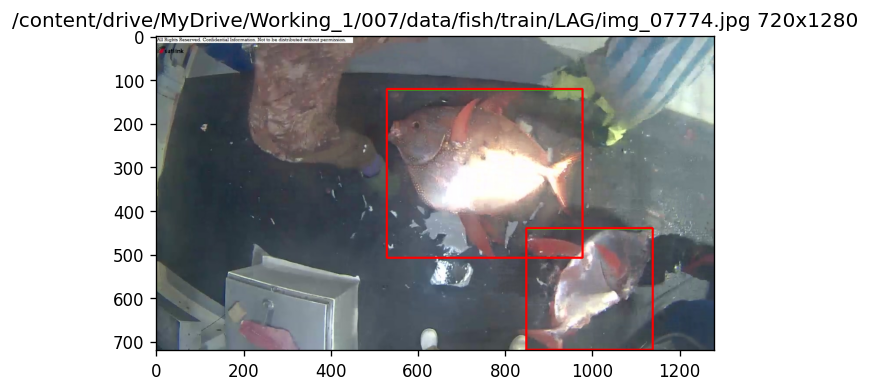

In [219]:
boxes_tmp = load_annotations()

annotation = boxes_tmp['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.3)

print(encoded.shape)
print(encoded[0,0,5:13])

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

In [200]:
annotation['fish_class']

'LAG'

In [201]:
encoded[0,0,...]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## Функция потерь

In [202]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):

    conf_loss = K.binary_crossentropy(y_true[..., 0],
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])

    # K.cast  приводит значения тензора к новому типу, здесь 'float32'
    # K.greater (сравнивает тензоры, возвращает булевое значение)

    # если abs_loss меньше 1, то считается по слагаемому со square_loss
    # если abs_loss больше 1, то считается по слагаемому с abs_loss

    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    # TODO: добавьте функцию потерь для классификации детекции
    # ---> стандартная категориальнгая кроссэнтропия при компиляции модели

    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)

    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)

    return total_conf_loss + 0.5 * loc_loss

## Загрузка данных

In [271]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):

    boxes = sum(boxes.values(), [])

    while True:
        shuffle(boxes)

        for i in range(len(boxes)//batch_size):
            X, y = [], []

            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])

                # TODO: добавьте one-hot encoding в разметку для классов
                # добавлено 8 элементов для классов рыб рядом со score и геометрическими отклонениями
                # в прямоугольниках

                #---было
                # y.append(encode_anchors(boxes[j], img_shape))
                # X.append(img)

                # --- стало
                target = encode_anchors(boxes[j], img_shape)[0,0,5:13].ravel()

                y.append(target)
                X.append(img)

            # формируется выход генератора при окончании внутреннего цикла for (обработан 1 батч картинок)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [272]:
output_0 = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции

# Вместо 5 используем 8 дополнительных слотов для one-hot кодировки видов рыб
x = tf.keras.layers.Conv2D(13,
                                kernel_size=(1, 1),
                                activation='linear',
                                kernel_regularizer='l2')(output_0)

#
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(8,  # многоклассовая классификация)
                          activation='softmax',  # функция активации
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)


model = tf.keras.models.Model(inputs=features.inputs, outputs=x, name = 'fish_classifier')
model.summary()

Model: "fish_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 750, 1200, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 750, 1200, 64)       │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 750, 1200, 64)       │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 375, 600, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 375, 600, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 375, 600, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 187, 300, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 187, 300, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 93, 150, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 93, 150, 512)        │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 46, 75, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 23, 37, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 23, 37, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 23, 37, 13)          │           6,6

 Total params: 14,723,517 (56.17 MB)

 Trainable params: 7,087,229 (27.04 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

## Обучение

In [279]:
# Checkpoint

from pathlib import Path
path = Path("/content/drive/MyDrive/Working_1/HW_3_comp_vision/fishdetector")
path.mkdir(exist_ok=True) # создаем папку для хранения промежуточных моделей с весами

cpt_filename = "{epoch:02d}_checkpoint_accuracy_{accuracy:.2f}_loss_{loss:.3f}.keras"
cpt_path = str(path / cpt_filename)

In [280]:
import keras

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# было
# model.compile(optimizer=adam,
#               loss=total_loss,
#               metrics=[confidence_loss])

# стало
model.compile(optimizer=adam,
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])


In [281]:
# Генерация данных для подачи в модель

batch_size = 5

shuffle(boxes)
gen = data_generator(boxes, batch_size=batch_size)

steps_per_epoch = 5

# Обучение модели
model.fit(gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          callbacks=[
            tf.keras.callbacks.ModelCheckpoint(cpt_path, \
                                               monitor='accuracy', \
                                               verbose=1, \
                                               save_best_only=True, \
                                               save_weights_only=False, \
                                               mode='max'),\
            ])

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63s/step - accuracy: 0.7567 - loss: 1.5893  
Epoch 1: accuracy improved from -inf to 0.80000, saving model to /content/drive/MyDrive/Working_1/HW_3_comp_vision/fishdetector/01_checkpoint_accuracy_0.80_loss_1.522.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 315s 63s/step - accuracy: 0.7639 - loss: 1.5782
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63s/step - accuracy: 0.4227 - loss: 2.0196  
Epoch 2: accuracy did not improve from 0.80000
5/5 ━━━━━━━━━━━━━━━━━━━━ 311s 63s/step - accuracy: 0.4322 - loss: 1.9981
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61s/step - accuracy: 0.7700 - loss: 1.3989  
Epoch 3: accuracy did not improve from 0.80000
5/5 ━━━━━━━━━━━━━━━━━━━━ 305s 61s/step - accuracy: 0.7750 - loss: 1.3672
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61s/step - accuracy: 0.8213 - loss: 1.1124  
Epoch 4: accuracy improved from 0.80000 to 0.84000, saving model to /content/drive/MyDrive/Working_1/HW_3_comp_vision/fishdetector/04_checkpoint_accuracy_0.84_loss_1.114.keras
5/

## Результат работы детектора

In [307]:
decoder_fish_dict = {'ALB': 0, 'BET': 1, 'DOL': 2, 'LAG': 3, 'SHARK': 4, \
             'YFT': 5, 'NoF': 6, 'Other': 7}

annotation = boxes['yft'][3]

_, sample_img = load_img(annotation['filename'])

# Вероятность принадлежности к одному из видов рыб
pred = model.predict(np.array([sample_img,]))

fish_index =np.argmax(pred,axis=1)

# Чтение словаря имя рыбы : номер класса = столбец в one_hot кодировке

def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

print(get_key(decoder_fish_dict, fish_index))


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
YFT


In [308]:
pred[0]

array([2.2048082e-16, 5.4885204e-06, 1.4330536e-07, 7.8516770e-08,
       5.3843618e-09, 9.9989629e-01, 9.7923694e-05, 3.9269805e-09],
      dtype=float32)

## Визуализируем предсказание на тесте

In [320]:
# Получение изображений для тестовых картинок

from matplotlib import pyplot as plt

test_images = glob('/content/drive/MyDrive/Working_1/007/data/fish/test_stg1/*.jpg')

images_to_plt = []

for i, filename in enumerate(test_images):

    short_file_name = os.path.basename(filename)

    img = cv2.imread(filename, cv2.IMREAD_COLOR)[...,::-1]
    images_to_plt.append(img)


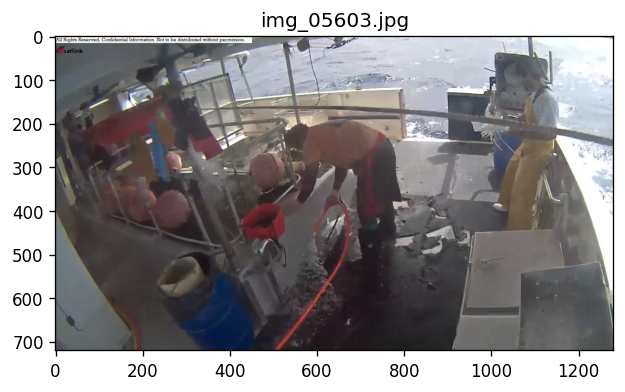

In [333]:
# отрисовка тестовой картинки по номеру картинки в списке (всего 16 картинок)
plt_index = 15

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(images_to_plt[plt_index])
plt.title('{}'.format(short_file_name));

In [334]:
# Предсказания распределения вероятностей для тестовой выборки

import pandas as pd

df = pd.DataFrame({'image': [], 'ALB': [], 'BET': [], 'DOL': [], \
                                'LAG': [], 'NoF': [], 'Other': [], \
                                'SHARK': [], 'YFT': []
                  })

test_images = glob('/content/drive/MyDrive/Working_1/007/data/fish/test_stg1/*.jpg')

# plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):

    # короткое имя файла
    short_file_name = os.path.basename(filename)

    _, sample_img = load_img(filename)

    # Predict
    pred = model.predict(np.array([sample_img,]))

    pred_to_submission = pred[0].copy()

    pred_to_submission[4] = pred[0][6]
    pred_to_submission[5] = pred[0][7]
    pred_to_submission[6] = pred[0][4]
    pred_to_submission[7] = pred[0][5]

    # # Добавляем строку в конец датафрейма
    # df.loc[i] = [short_file_name, pred_to_submission[0],pred_to_submission[1],
    #                         pred_to_submission[2],pred_to_submission[3],
    #                         pred_to_submission[4],pred_to_submission[5],
    #                         pred_to_submission[6],pred_to_submission[7]]

    # Добавляем строку в конец датафрейма
    df.loc[i] = [short_file_name, round(pred_to_submission[0], 1), round(pred_to_submission[1], 1),
                            round(pred_to_submission[2], 1), round(pred_to_submission[3], 1),
                            round(pred_to_submission[4], 1), round(pred_to_submission[5], 1),
                            round(pred_to_submission[6], 1), round(pred_to_submission[7], 1)
                 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

In [335]:
result_df = df.set_index('image')
result_df


,ALB,BET,DOL,LAG,NoF,Other,SHARK,YFT
image,,,,,,,,
img_00618.jpg,0.4,0.3,0.0,0.0,0.0,0.1,0.0,0.1
img_01116.jpg,0.0,0.7,0.0,0.0,0.0,0.0,0.0,0.2
img_02890.jpg,0.0,0.2,0.0,0.0,0.1,0.0,0.0,0.7
img_00282.jpg,0.0,0.2,0.0,0.0,0.1,0.0,0.0,0.6
img_02920.jpg,0.0,0.9,0.0,0.0,0.0,0.0,0.0,0.1
img_01222.jpg,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.2
img_02188.jpg,0.0,0.1,0.1,0.0,0.1,0.0,0.1,0.6
img_03454.jpg,0.0,0.2,0.2,0.1,0.1,0.1,0.1,0.3
img_03584.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [336]:
result_df.to_csv('v1_submission_fish_classifier.csv')

## Итоги
1. Решалась задача классификации видов рыб на изображении
на базе ноутбука по предварительной детекции рыб на изображении
2. Внесены изменения
- в функцию load_annotations() добавлена метка класса рыбы, поле ['fish_class']
- вид рыбы (8 классов) представлен в виде one-hot вектора размерности (,8) и  добавлен справа в размерность со score (качество якорного квадрата) и параметрами прямоугольника детекции (dx,dy,dw,dh). Параметры вектора в этой размерности увеличились с 5 до 13
- соответственно в модели в последнем слое свертки
1/ параметр изменился с 5 до 13 выходов
2/ далее применен слой GlobalAveragePooling
3/ за ним слой dense на 8 нейронов c функцией активации softmax
- функция потерь CategoricalCrossEntropy и метрика accuracy

3. При обучении на 10 эпохах модель показала максимальную accuracy выше 96%, и последние 3 эпохи стабильную accuracy выше 84%

4. Сделаны предсказания на тестовой выборке, в данных представлены рыбы вида 'BEL' и 'YFT'

Примечание: размер анкерного квадрата составлял 150*150, его можно сделать меньше для большей детализации